# Usinge pre-trained U-Net model with EfficientNet B4 backbone for inference

In [1]:
import numpy as np
import pandas as pd
import pyreadr as pyr
from sys import getsizeof
import random
import cv2
import os
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import segmentation_models as sm # 
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from patchify import patchify

sm.set_framework('tf.keras')
sm.framework()
random_seed = 1234

Segmentation Models: using `keras` framework.


## Load the satellite imagery and corresponding masks

Because all available images were used for model training for each of the 5 test folds one images is randomly selected and the prediction of the coresponding model is displayed.

In [2]:
# Fold 1
test_img_CV1 = np.load("/path/image_segmentation/CV1_test_imgs_all_patch.npy")
test_mask_CV1 = np.load("/path/image_segmentation/CV1_test_mask_all_patch.npy")

# Fold 2
test_img_CV2 = np.load("/path/image_segmentation/CV2_test_imgs_all_patch.npy")
test_mask_CV2 = np.load("/path/image_segmentation/CV2_test_mask_all_patch.npy")

# Fold 3
test_img_CV3 = np.load("/path/image_segmentation/CV3_test_imgs_all_patch.npy")
test_mask_CV3 = np.load("/path/image_segmentation/CV3_test_mask_all_patch.npy")

# Fold 4
test_img_CV4 = np.load("/path/image_segmentation/CV4_test_imgs_all_patch.npy")
test_mask_CV4 = np.load("/path/image_segmentation/CV4_test_mask_all_patch.npy")

# Fold 5
test_img_CV5 = np.load("/path/image_segmentation/CV5_test_imgs_all_patch.npy")
test_mask_CV5 = np.load("/path/image_segmentation/CV5_test_mask_all_patch.npy")

In [3]:
idx = np.random.randint(0, len(test_img_CV1), 1)

## Load models

In [137]:
def inference(backbone, model_name, input_img):
            
    batchsize = 8
    n_classes = 9
    lr = 0.0001
    decay = 0.000001


    metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
               sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               tf.keras.metrics.MeanIoU(num_classes=n_classes)]

    ## Load U-net backbone
    backbone_model = keras.models.load_model("/path/u_net_models/model_u_%s_image_net_weights.hdf5" %backbone)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8])
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_name)
    
    if input_img.shape==(512,512,3):
        input_img=np.expand_dims(input_img, axis=0)
        
        
    def test_time_augmentation(imgs):
        pred_mask=[]

        for i in range(0, len(imgs)):
            p0 = backbone_model.predict(np.expand_dims(imgs[i], axis=0))[0]

            p1 = backbone_model.predict(np.expand_dims(np.fliplr(imgs[i]), axis=0))[0]
            p1 = np.fliplr(p1)

            p2 = backbone_model.predict(np.expand_dims(np.flipud(imgs[i]), axis=0))[0]
            p2 = np.flipud(p2)

            p3 = backbone_model.predict(np.expand_dims(np.fliplr(np.flipud(imgs[i])), axis=0))[0]
            p3 = np.fliplr(np.flipud(p3))

            avg_pred = (p0 + p1 + p2 + p3)/4
            pred_mask.append(avg_pred)
        return pred_mask

    
    return np.array(test_time_augmentation(input_img))

## Model inference on selected images

In [ ]:
with tf.device('/gpu:0'):
    pred_1 = inference("effnetb4", "effnetb4_focc_jacc_10", test_img_CV1[idx])
    pred_2 = inference("effnetb4", "effnetb4_focc_jacc_11", test_img_CV2[idx])
    pred_3 = inference("effnetb4", "effnetb4_focc_jacc_12", test_img_CV3[idx])
    pred_4 = inference("effnetb4", "effnetb4_focc_jacc_13", test_img_CV4[idx])
    pred_5 = inference("effnetb4", "effnetb4_focc_jacc_14", test_img_CV5[idx])

In [115]:
def show_mask_and_prediction(img, true, pred, i, j):
    cmap_custom = (mpl.colors.ListedColormap(["black",'tan', 'limegreen', 'gray', 'white',
                                          "darkgreen", "royalblue", "wheat", "firebrick"]))
    #https://matplotlib.org/stable/gallery/color/named_colors.html
    
    img = img[i]
    true = true[i]
    pred = pred[0,:,:,:]

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Original image')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])  
    plt.ylabel("Evaluated on fold "+str(j))
    plt.subplot(232)
    plt.title('Original mask')
    plt.imshow(np.argmax(true, axis=-1), cmap=cmap_custom, vmin=0, vmax=8)
    plt.axis("off")
    plt.subplot(233)
    plt.title('Prediction')
    plt.imshow(np.argmax(pred, axis=-1), cmap=cmap_custom, vmin=0, vmax=8)
    plt.axis("off")
   # plt.show()

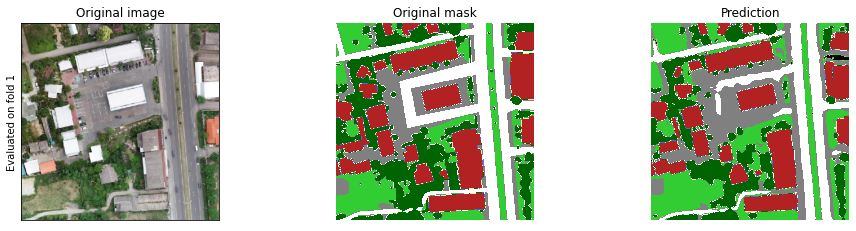

In [113]:
show_mask_and_prediction(test_img_CV1, test_mask_CV1, pred_1, idx.item(0), 1)
plt.savefig("/path/image_segmentation/inference_CV1",
            bbox_inches='tight', pad_inches = 0.1, facecolor='white')

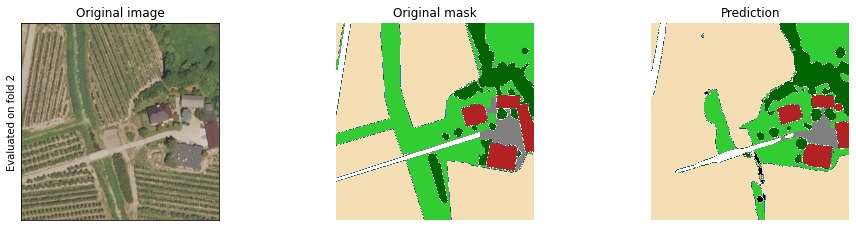

In [114]:
show_mask_and_prediction(test_img_CV2, test_mask_CV2, pred_2, idx.item(0), 2)
plt.savefig("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/inference_CV2",
            bbox_inches='tight', pad_inches = 0.1, facecolor='white')

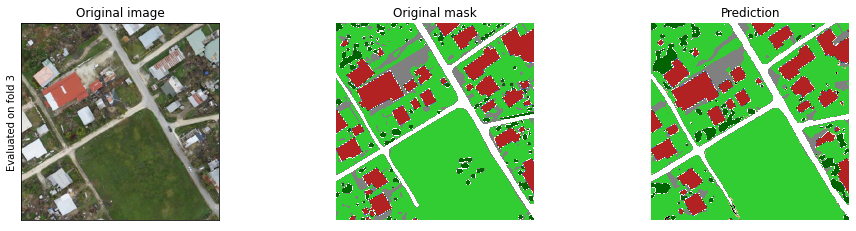

In [115]:
show_mask_and_prediction(test_img_CV3, test_mask_CV3, pred_3, idx.item(0), 3)
plt.savefig("/path/image_segmentation/inference_CV3",
            bbox_inches='tight', pad_inches = 0.1, facecolor='white')

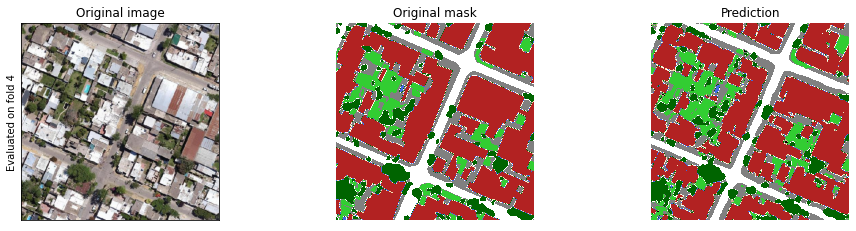

In [116]:
show_mask_and_prediction(test_img_CV4, test_mask_CV4, pred_4, idx.item(0), 4)
plt.savefig("/path/image_segmentation/inference_CV4",
            bbox_inches='tight', pad_inches = 0.1, facecolor='white')

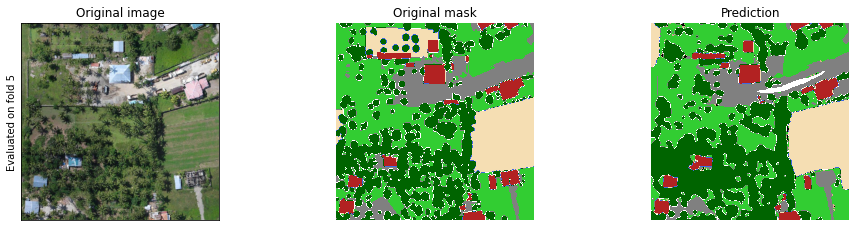

In [117]:
show_mask_and_prediction(test_img_CV5, test_mask_CV5, pred_5, idx.item(0), 5)
plt.savefig("/path/image_segmentation/inference_CV5",
            bbox_inches='tight', pad_inches = 0.1, facecolor='white')

## Inference with TTA and model ensemble

In [ ]:
with tf.device('/cpu:0'): 
    model_names=["effnetb4_focc_jacc_10", "effnetb4_focc_jacc_11", "effnetb4_focc_jacc_12", "effnetb4_focc_jacc_13", "effnetb4_focc_jacc_14"]
    backbone="effnetb4"
    input_img = test_img_CV1[:1]
    batchsize = 8
    n_classes = 9
    lr = 0.0001
    decay = 0.000001

    metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
               sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               tf.keras.metrics.MeanIoU(num_classes=n_classes)]


    ## Load U-net backbone
    backbone_model = keras.models.load_model("/path/u_net_models/model_u_%s_image_net_weights.hdf5" %backbone)


    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8])


    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)


    ## Expand dimensions if single image
    if input_img.shape==(512,512,3):
        input_img=np.expand_dims(input_img, axis=0)
        
        
    ## Load and compile models  
    bb_model_1 = keras.models.clone_model(backbone_model)
    bb_model_1.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_1.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_names[0])
    
    bb_model_2 = keras.models.clone_model(backbone_model)
    bb_model_2.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_2.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_names[1])
    
    bb_model_3 = keras.models.clone_model(backbone_model)
    bb_model_3.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_3.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_names[2])
    
    bb_model_4 = keras.models.clone_model(backbone_model)
    bb_model_4.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_4.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_names[3])
    
    bb_model_5 = keras.models.clone_model(backbone_model)
    bb_model_5.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_5.load_weights("/path/image_segmentation/u_net_models_mc/u_net_%s" %model_names[4])


    ## Test time augmentation for single image
    def TTA(bb_model, img):

        p0 = bb_model.predict(img)

        p1 = bb_model.predict(np.fliplr(img))
        p1 = np.fliplr(p1)

        p2 = bb_model.predict(np.flipud(img))
        p2 = np.flipud(p2)

        p3 = bb_model.predict(np.fliplr(np.flipud(img)))
        p3 = np.fliplr(np.flipud(p3))

        avg_pred = (p0 + p1 + p2 + p3)/4
        return avg_pred
    
    
    ## Average ensemble prediction
    def model_ensemble(img, bb_m1, bb_m2, bb_m3, bb_m4, bb_m5):
        pred_ensemble=[] 
        pred_ensemble.append(np.array(TTA(bb_m1, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m2, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m3, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m4, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m5, img))[0,:,:,:])
        return np.mean(np.array(pred_ensemble), axis=0)
    

The following lines of code run the model_ensemble() function on a set of images with shape (N, 512, 512, 3) for inference. Keep in mind that model 2 - model 5 were trained on the displayed images. However, the aim of this part is to show how to use the ensemble model with TTA for inference and not to validate the model's performance.

In [117]:
with tf.device('/gpu:0'): 
    
    images=test_img_CV1[:4]
    pred=[]
    
    for img_ in images:
        if img_.shape == (512,512,3):
            img_ = np.expand_dims(img_, axis=0)
        pred.append(model_ensemble(img_, bb_model_1,bb_model_2, bb_model_3, bb_model_4, bb_model_5))
        
    pred = np.array(pred)

In [128]:
def show_mask_and_prediction(img, true, pred, i):
    cmap_custom = (mpl.colors.ListedColormap(["black",'tan', 'limegreen', 'gray', 'white',
                                          "darkgreen", "royalblue", "wheat", "firebrick"]))
    #https://matplotlib.org/stable/gallery/color/named_colors.html
    
    img = img[i]
    true = true[i]
    pred = pred[i]

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Original image')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])  
    plt.ylabel("Evaluated on all folds")
    plt.subplot(232)
    plt.title('Original mask')
    plt.imshow(np.argmax(true, axis=-1), cmap=cmap_custom, vmin=0, vmax=8)
    plt.axis("off")
    plt.subplot(233)
    plt.title('Prediction')
    plt.imshow(np.argmax(pred, axis=-1), cmap=cmap_custom, vmin=0, vmax=8)
    plt.axis("off")

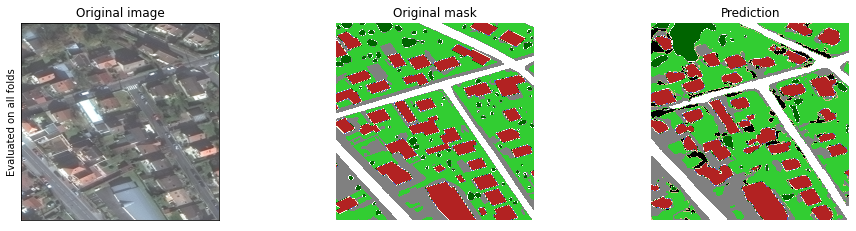

In [129]:
show_mask_and_prediction(test_img_CV1, test_mask_CV1, pred, 0)

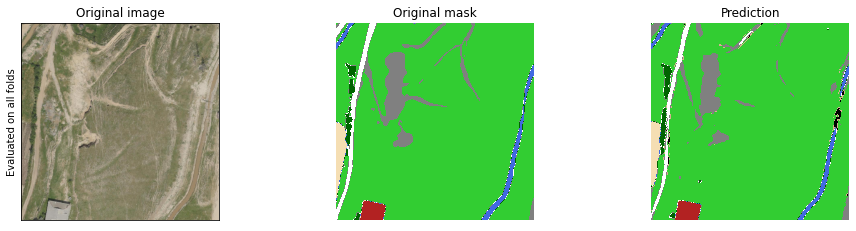

In [130]:
show_mask_and_prediction(test_img_CV1, test_mask_CV1, pred, 1)

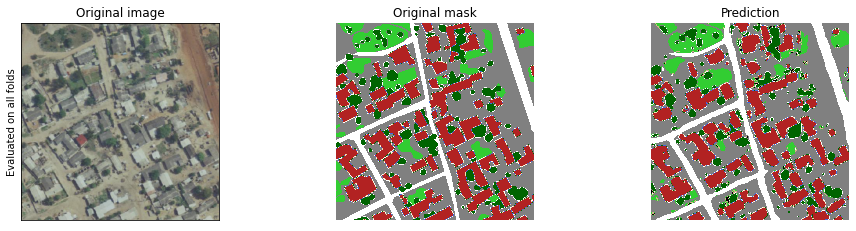

In [131]:
show_mask_and_prediction(test_img_CV1, test_mask_CV1, pred, 2)

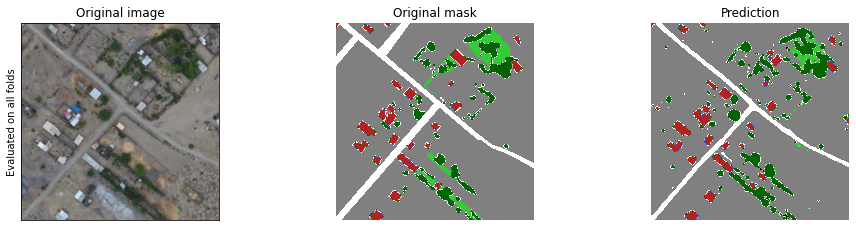

In [132]:
show_mask_and_prediction(test_img_CV1, test_mask_CV1, pred, 3)